# 0.) Import and Clean data

In [48]:
import pandas as pd
from imblearn.over_sampling import SMOTE
#from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlens.ensemble import SuperLearner
import seaborn as sns

In [2]:
df = pd.read_csv('bank-additional-full.csv')

In [3]:
df = df.drop(["default", "pdays",	"previous",	"poutcome",	"emp.var.rate",	"cons.price.idx",	"cons.conf.idx",	"euribor3m",	"nr.employed"], axis = 1)
df = pd.get_dummies(df, columns = ["loan", "job","marital","housing","contact","day_of_week", "campaign", "month", "education"],drop_first = True)
df.head()

,age,duration,y,loan_unknown,loan_yes,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_nov,month_oct,month_sep,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown
0,56,261,no,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,57,149,no,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,37,226,no,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,40,151,no,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,56,307,no,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [4]:
y = pd.get_dummies(df["y"], drop_first = True)
X = df.drop(["y"], axis = 1)

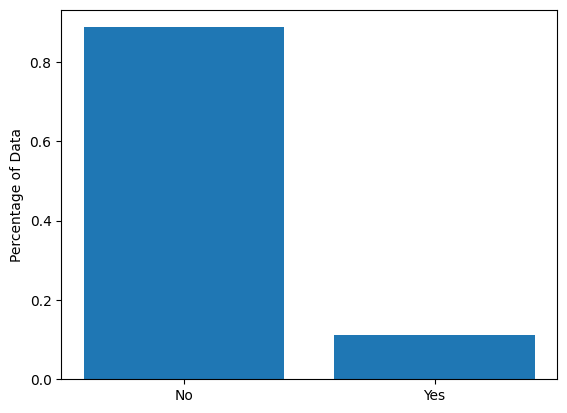

In [11]:
obs = len(y)
plt.bar(["No","Yes"],[len(y[y.yes==0])/obs,len(y[y.yes==1])/obs])
plt.ylabel("Percentage of Data")
plt.show()

In [10]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler().fit(X_train)

X_scaled = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 1.) Based on the visualization above, use your expert opinion to transform the data based on what we learned this quarter

In [12]:
# Set SMOTE to ratio of desired obs each time
smnc = SMOTE(sampling_strategy = 0.5, random_state = 333)
sm_X, sm_y = smnc.fit_resample(X_scaled, y_train)

X_scaled = sm_X
y_train = sm_y

# 2.) Build and visualize a decision tree of Max Depth 3. Show the confusion matrix.

In [13]:
dtree_class = DecisionTreeClassifier(max_depth = 3)
dtree = dtree_class.fit(X_scaled, y_train)

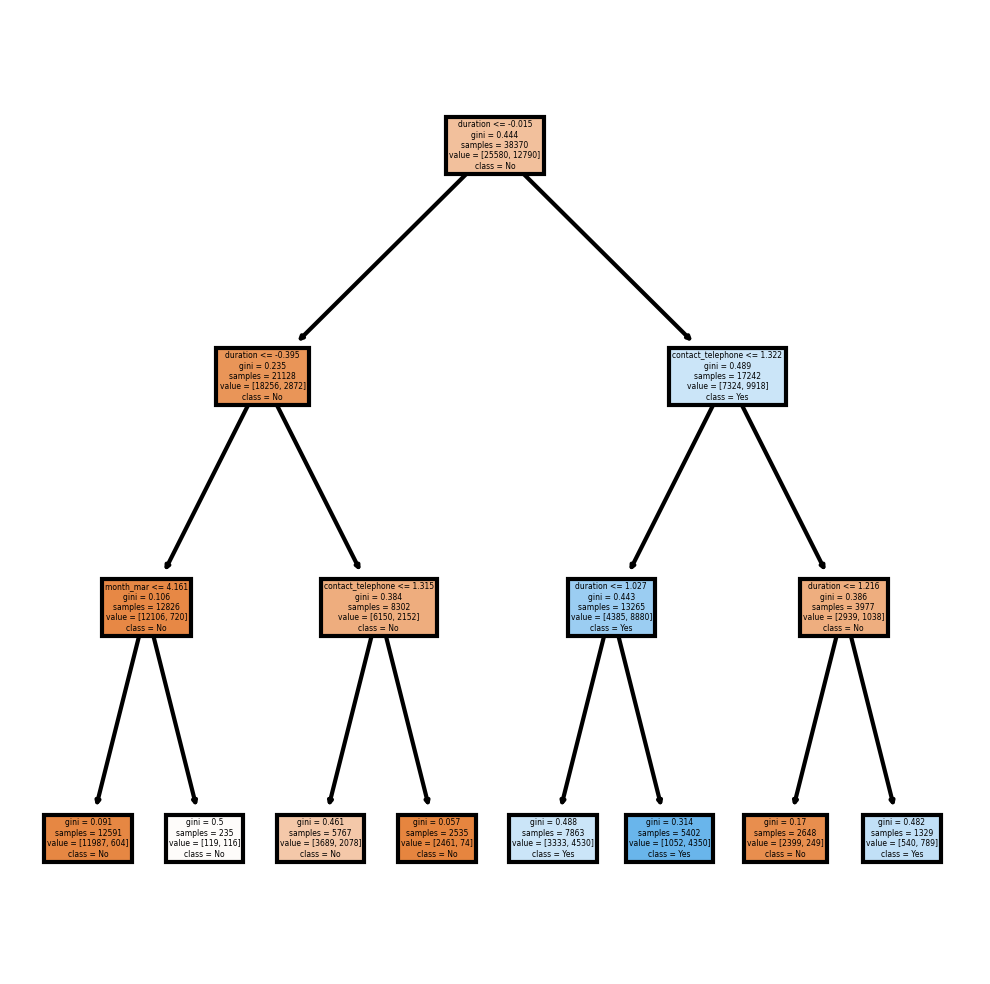

In [14]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
plot_tree(dtree, filled = True, feature_names = X.columns, class_names=["No","Yes"])
plt.show()

# 1b.) Confusion matrix on out of sample data. Visualize and store as variable

In [15]:
y_pred_tree = dtree.predict(X_test)
y_true = y_test
cm_tree = confusion_matrix(y_true, y_pred_tree)

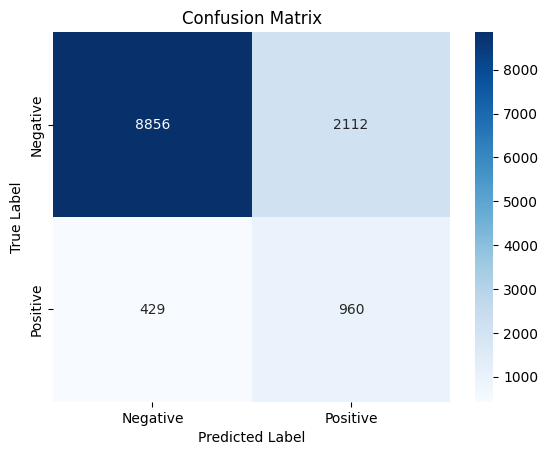

In [16]:
class_labels = ['Negative', 'Positive']

# Plot the confusion matrix as a heatmap
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 3.) Use bagging on your descision tree

In [17]:
#Ideally would want to optimizie on max depth, max samples, etc
bagging_class = BaggingClassifier(estimator = dtree_class, n_estimators = 100, max_samples= 0.5, max_features = 1)

In [18]:
bagging = bagging_class.fit(X_scaled, y_train)
y_pred_bag = bagging.predict(X_test)

cm_bag = confusion_matrix(y_true, y_pred_bag)

/Applications/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


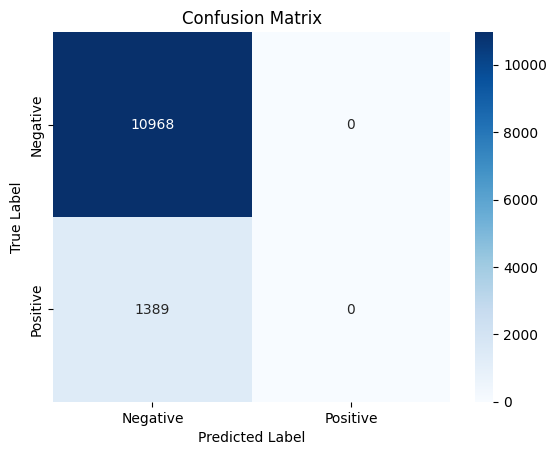

In [19]:
# Plot the confusion matrix as a heatmap
sns.heatmap(cm_bag, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 4.) Boost your tree

In [20]:
boost_class = AdaBoostClassifier(estimator = dtree_class, n_estimators = 50)

In [21]:
boost = boost_class.fit(X_scaled, y_train)
y_pred_boost = boost.predict(X_test)

cm_boost = confusion_matrix(y_true, y_pred_boost)

/Applications/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


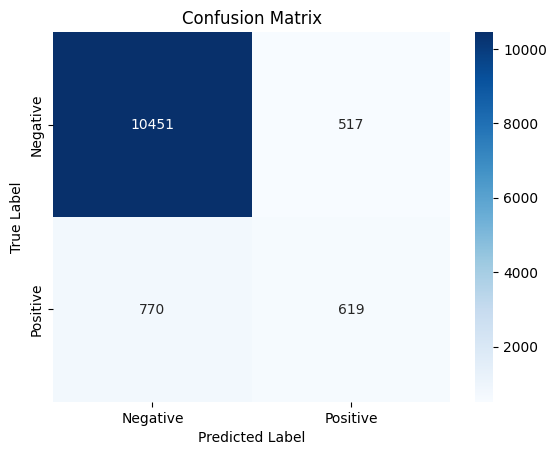

In [22]:
# Plot the confusion matrix as a heatmap
sns.heatmap(cm_boost, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 5.) Train a Logistic Regression on the Decision Tree, the Boosted Tree, and the Bagged Tree. Interpret coefficients and significance

In [39]:
#Fit logistic regression on all 3 of these, predicting your y train

data = {
    "Intercept": np.ones(len(y_train)),
    "DTree": dtree.predict(X_scaled),
    "Bagging": bagging.predict(X_scaled),
    "Boosting": boost.predict(X_scaled)
}

data = pd.DataFrame(data)

X_test_super = {
    "Intercept": np.ones(len(X_test)),
    "DTree": dtree.predict(X_test),
    "Bagging": bagging.predict(X_test),
    "Boosting": boost.predict(X_test)
}

X_test_super = pd.DataFrame(X_test_super)

In [40]:
super_learner = LogisticRegression()
super_learner_out = super_learner.fit(data, y_train)
y_pred_super = super_learner_out.predict(X_test_super)

/Applications/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [52]:
super_learner_out.coef_

array([[-1.25245762e-03,  1.39473293e+00,  0.00000000e+00,
         4.40729543e+00]])

In [42]:
cm_super = confusion_matrix(y_true, y_pred_super)

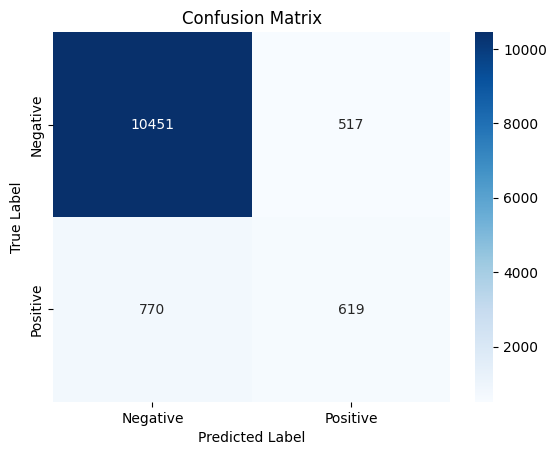

In [43]:
# Plot the confusion matrix as a heatmap
sns.heatmap(cm_boost, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Based on the coefficients from the super learner we can see the relative importance of the base models to the super learner. Here we can see that the coefficient for the bagged model is the lowest at 0, so this model is very unimportant to the super learner, whereas the decision tree model is a little more important, but the boosted model is clearly the most important, with the highest coefficient of 4.41. Therefore, it makes sense that our confusion matrices are identical for our boosted model and our super learner since it appears to be pulling from the boosted model the most.